Foreign holdings (ratio) seem to have a high correlation with stock prices
- This should be natural if foreign investors play a key role in controlling prices
- However, it appears that foreign investors may act more quickly in response to steep price declines (just a hypothesis)

Implications
- If a certain stock has incresing or consistently high foreign holdings while prices are declining,  it might be a good startegy to consider for investment
- If foreign investers are rapidly selling, it could serve as a sell signal for us as well

Insights
- This analysis could yield interesting and meaningful insights: which companies' stock prices are highly correlated with foreign investors 
    - However, several additional aspects need to be considered: trading volume, financial stability, the absolute amount of foreign holdings, as well as the volatility of foreign holdings
- Certain stocks exhibit high correlations with D, W, M (last 30 data points) both individually and collectively 
    - For these companies, we should closely monitor foreign holdigs going forward, and develop appropriate strategies accordingly (**strategy to be developed**)
- On the other hand, certain stocks display high correlations with repsect to W, M, but show little to no correlations (or negative correlation) with respect to D 
    - For these companies, opportunities maybe already at present (**strategy to be developed**)

In [1]:
import pandas as pd
from mojito import *  # Recommended to use koreainvest_module.py instead due to the issue with the path to the /config/token.dat (varies..)

with open('../../config/config.json', 'r') as json_file:
    config = json.load(json_file)
    key = config['key']
    secret = config['secret']
    acc_no = config['acc_no']
    # key_mock = config['key_mock']
    # secret_mock = config['secret_mock']
    # acc_no_mock = config['acc_no_mock']

broker = KoreaInvestment(api_key=key, api_secret=secret, acc_no=acc_no, mock=False)
# broker = KoreaInvestment(api_key=key_mock, api_secret=secret_mock, acc_no=acc_no_mock, mock=True)

def fetch_foreign_holdings(code, period): 
    # period: D, W, M
    base_url = "https://openapi.koreainvestment.com:9443"
    path = "/uapi/domestic-stock/v1/quotations/inquire-daily-price"
    url = f"{base_url}/{path}"
    headers = {
        "content-type": "application/json; charset=utf-8",
        "authorization": broker.access_token,
        "appKey": broker.api_key,
        "appSecret": broker.api_secret,
        "tr_id": "FHKST01010400",
        "tr_cont": "",
    }

    params = {
        "fid_cond_mrkt_div_code": "J",
        "fid_input_iscd": code,
        "FID_PERIOD_DIV_CODE":period, 
        "FID_ORG_ADJ_PRC":"0000000000" # modified stock prices
    }

    res = requests.get(url, headers=headers, params=params)
    if res.json()['rt_cd'] == '0' and len(res.json()['output']) > 0:
        res = pd.DataFrame(res.json()['output'])
    else: 
        return None

    type_casting = {'stck_clpr':'int', 'hts_frgn_ehrt':'float'}
    res = res.astype(type_casting)
    foreign_holdings = res.set_index('stck_bsop_date')[['stck_clpr', 'hts_frgn_ehrt']].sort_index()
    corr = foreign_holdings['stck_clpr'].corr(foreign_holdings['hts_frgn_ehrt'])

    return foreign_holdings, corr

def fetch_all_foreign_holdings(code): 
    fh_d, cr_d = fetch_foreign_holdings(code, 'D')
    fh_w, cr_w = fetch_foreign_holdings(code, 'W')
    fh_m, cr_m = fetch_foreign_holdings(code, 'M')

    fh_d = fh_d.reset_index().rename(columns={'stck_bsop_date':'date_d', 'stck_clpr':'price_d', 'hts_frgn_ehrt':'fh_d'})
    fh_w = fh_w.reset_index().rename(columns={'stck_bsop_date':'date_w', 'stck_clpr':'price_w', 'hts_frgn_ehrt':'fh_w'})
    fh_m = fh_m.reset_index().rename(columns={'stck_bsop_date':'date_m', 'stck_clpr':'price_m', 'hts_frgn_ehrt':'fh_m'})

    fh = pd.concat([fh_d, fh_w, fh_m], axis=1)
    return fh, [code, cr_d, cr_w, cr_m]

def fetch_corr_foreign_holdings(code): 
    fh_d, cr_d = fetch_foreign_holdings(code, 'D')
    fh_w, cr_w = fetch_foreign_holdings(code, 'W')
    fh_m, cr_m = fetch_foreign_holdings(code, 'M')

    return [code, cr_d, cr_w, cr_m]

In [2]:
# prepration of the target companies set
import time

MARCAP_THRESHOLD = 5000*10**8 
IPO_YEAR_THRESHOLD = 3 

df_krx = pd.read_feather('data/df_krx.feather')
df_krx = df_krx.loc[df_krx['Marcap'] >= MARCAP_THRESHOLD]
df_krx = df_krx.loc[pd.Timestamp.today()- df_krx['ListingDate'] > pd.Timedelta(days = IPO_YEAR_THRESHOLD*(365+1))]
print(len(df_krx))

corr = []
i = 0
for code in df_krx.index:
    corr_ = fetch_corr_foreign_holdings(code)
    print(i)
    i += 1
    time.sleep(0.1)
    corr_.append(df_krx.loc[code, 'Name'])
    corr.append(corr_)
    print(corr_)

corr = pd.DataFrame(corr, columns=['code', 'd', 'w', 'm', 'name'])

corr['average'] = corr[['d', 'w', 'm']].mean(axis=1)
corr['std']= corr[['d', 'w', 'm']].std(axis=1)
# corr.to_feather('data/corr_20230930.feather')
corr.to_feather('data/corr_20240521.feather')

393
0
['005930', -0.12400210562409358, 0.7432911381500154, 0.905859235532235, '삼성전자']
1
['000660', 0.7909320851810713, 0.9762670441479679, 0.8761066931143916, 'SK하이닉스']
2
['207940', 0.6115098670665327, 0.7991355573859105, 0.23969451548266327, '삼성바이오로직스']
3
['005380', 0.7747067691286005, 0.8874867136308323, 0.7983485061905683, '현대차']
4
['000270', 0.22797813106716608, 0.9540598361438459, 0.8232869559533156, '기아']
5
['068270', 0.8562589403067103, 0.33225059449801836, 0.6526453858910234, '셀트리온']
6
['005490', 0.12440958459454711, -0.5987234776624967, -0.8593714124373361, 'POSCO홀딩스']
7
['051910', 0.16928832896585652, 0.8133259994841238, 0.7937463026939741, 'LG화학']
8
['028260', 0.39909761187496656, 0.7659271551665293, 0.8076067643070465, '삼성물산']
9
['035420', 0.5822433485329114, 0.9110074329677107, 0.8265028159715103, 'NAVER']
10
['006400', 0.4274341142558391, 0.306693074887807, 0.6783639433538544, '삼성SDI']
11
['105560', 0.8560650045699381, 0.9440357208951602, 0.711332090281556, 'KB금융']
12
['0

c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


249
['078130', nan, nan, -0.3765988630600573, '국일제지']
250
['089030', 0.6056203059481532, 0.7905935437408463, 0.6702788450708026, '테크윙']
251
['365550', -0.5290108856645553, -0.913382033442478, -0.0629263992978289, 'ESR켄달스퀘어리츠']
252
['031980', 0.11352426892284712, 0.8199601472323701, -0.4297750056671257, '피에스케이홀딩스']
253
['336370', 0.30042455453599737, 0.40199817379714553, 0.10133387236559342, '솔루스첨단소재']
254
['278280', 0.20014563001896196, 0.4382412687641161, 0.5814979634671577, '천보']
255
['003540', -0.5292639620652695, 0.3649883588593323, 0.6642554007225875, '대신증권']
256
['003850', -0.5677230724979795, 0.5817195754947038, 0.5914302595387704, '보령']
257
['000400', 0.43652565118988884, -0.6383828239318434, 0.6272336638255148, '롯데손해보험']
258
['214320', 0.9239516541124086, -0.020092744231279075, 0.05085782933663275, '이노션']
259
['089590', 0.9021672238604982, 0.7509486828675729, -0.5821940464323417, '제주항공']
260
['181710', -0.47862086877644927, -0.38750394693590645, 0.8694209121931594, 'NHN']
261


c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


315
['136510', nan, nan, 0.6400154866567902, '스마트솔루션즈']
316
['001680', 0.9224533974824353, 0.5074537518116666, 0.210538549205547, '대상']
317
['272290', 0.6728025709440497, -0.10589292830628247, 0.32401549244736466, '이녹스첨단소재']
318
['131290', 0.1398838785815815, 0.8385085809204726, 0.4541693175774106, '티에스이']
319
['268280', 0.864038424987363, 0.7709784257385894, 0.6473423144623012, '미원에스씨']
320
['064960', -0.30565481012969214, -0.6090958810773818, 0.05672990803596587, 'SNT모티브']
321
['344820', 0.5729098954946993, 0.0816812657296206, 0.4405126878014367, 'KCC글라스']
322
['094360', -0.8935118183479442, -0.14449132663370987, 0.12642225007322655, '칩스앤미디어']
323
['019170', 0.5133552626862671, 0.27294888352110747, 0.17502464106454332, '신풍제약']
324
['183300', -0.9227659952543744, -0.809443324081777, -0.7640289154788333, '코미코']


c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\user\projects\trader\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


325
['253590', nan, nan, nan, '네오셈']
326
['058610', 0.2499338316862493, 0.28902910937001136, -0.03252188471359735, '에스피지']
327
['005440', 0.11871241042646767, -0.039319944611895585, 0.3697613370010599, '현대지에프홀딩스']
328
['000070', 0.46795680939350537, 0.5499066358164094, 0.21642054325609125, '삼양홀딩스']
329
['005880', 0.9531533197540516, 0.35650018211960366, 0.31444805444732216, '대한해운']
330
['082740', 0.6242259761284541, -0.180237211347126, 0.43582439487410074, 'HSD엔진']
331
['003280', -0.09894611486375608, 0.1631553725724631, 0.17008767587857065, '흥아해운']
332
['079370', -0.05586280248310753, -0.6695385330880782, -0.7143207813754429, '제우스']
333
['293940', -0.33354979441208776, -0.16820958746499706, -0.7210867316327725, '신한알파리츠']
334
['200710', 0.5988411835961444, -0.2698109073577465, 0.4954089441732832, '에이디테크놀로지']
335
['001720', -0.8448683358167536, -0.367246079193759, -0.22296120660156188, '신영증권']
336
['095500', -0.4976815845705286, 0.1618940585444093, -0.20870450602756496, '미래나노텍']
337
['2

,code,d,w,m,name,average,std
1,000660,0.790932,0.976267,0.876107,SK하이닉스,0.881102,0.092768
3,005380,0.774707,0.887487,0.798349,현대차,0.820181,0.059475
31,024110,0.801501,0.727369,0.849632,기업은행,0.792834,0.061590
45,009540,0.927243,0.902559,0.856220,HD한국조선해양,0.895340,0.036058
50,005830,0.814120,0.781442,0.947696,DB손해보험,0.847752,0.088082
51,010140,0.903183,0.936744,0.889381,삼성중공업,0.909770,0.024359
68,267260,0.866976,0.974840,0.929792,HD현대일렉트릭,0.923869,0.054175
83,005940,0.898589,0.915235,0.900284,NH투자증권,0.904703,0.009160
90,271560,0.739419,0.894605,0.796845,오리온,0.810290,0.078462
106,036460,0.823629,0.735897,0.905665,한국가스공사,0.821730,0.084900


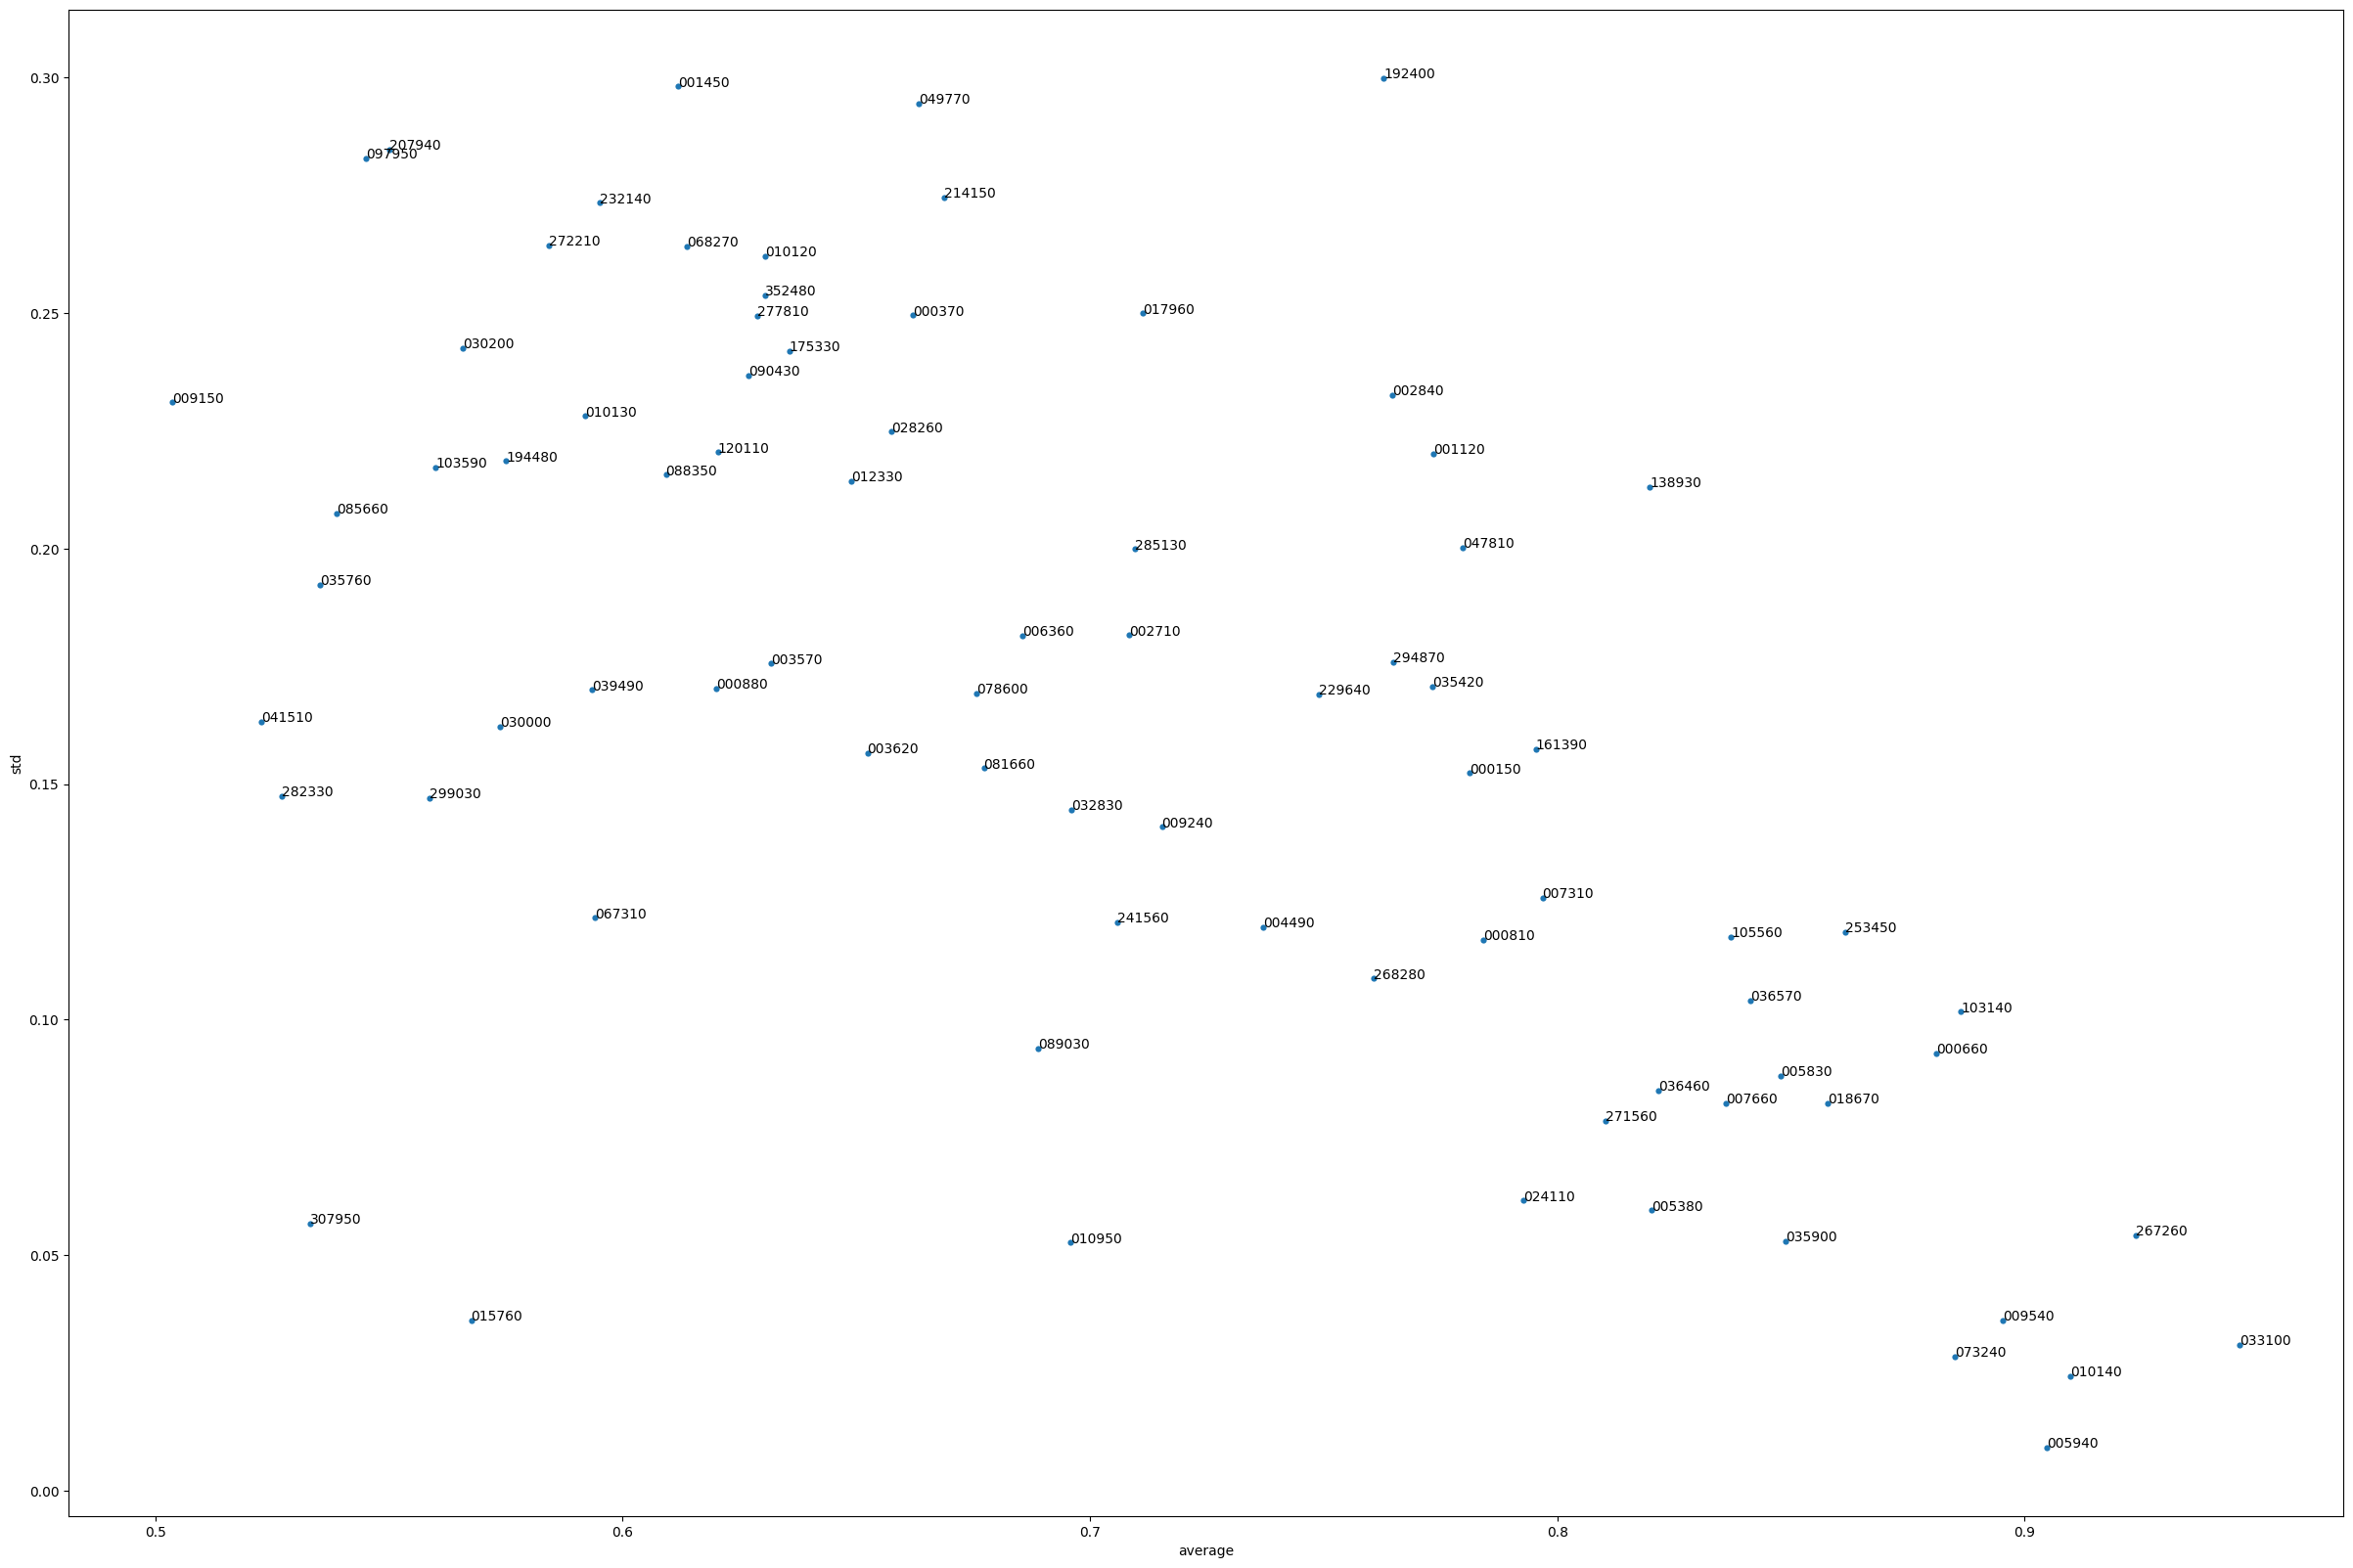

In [3]:
corr = pd.read_feather('data/corr_20240521.feather')
corr.dropna(inplace=True)

# corr_set comprises companies that are highly correlated with foreign investors
corr_set = corr.loc[(corr['average'] > 0.5) & (corr['std'] < 0.3)]
# display(corr_set)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
corr_set.plot('average', 'std', kind='scatter', ax=ax, linewidth=0, figsize=(30,20))

for k, v in corr_set[['average', 'std']].iterrows():  # k is index
    ax.annotate(corr_set.loc[k, 'code'], v)

# corr_top comprises the companies that are most highly correlated with foreign investors
corr_top = corr.loc[(corr['average'] > 0.7) & (corr['std'] < 0.1)]
display(corr_top)



SK하이닉스
현대차
기업은행
HD한국조선해양
DB손해보험
삼성중공업
HD현대일렉트릭
NH투자증권
오리온
한국가스공사
이수페타시스
JYP Ent.
금호타이어
SK가스
제룡전기


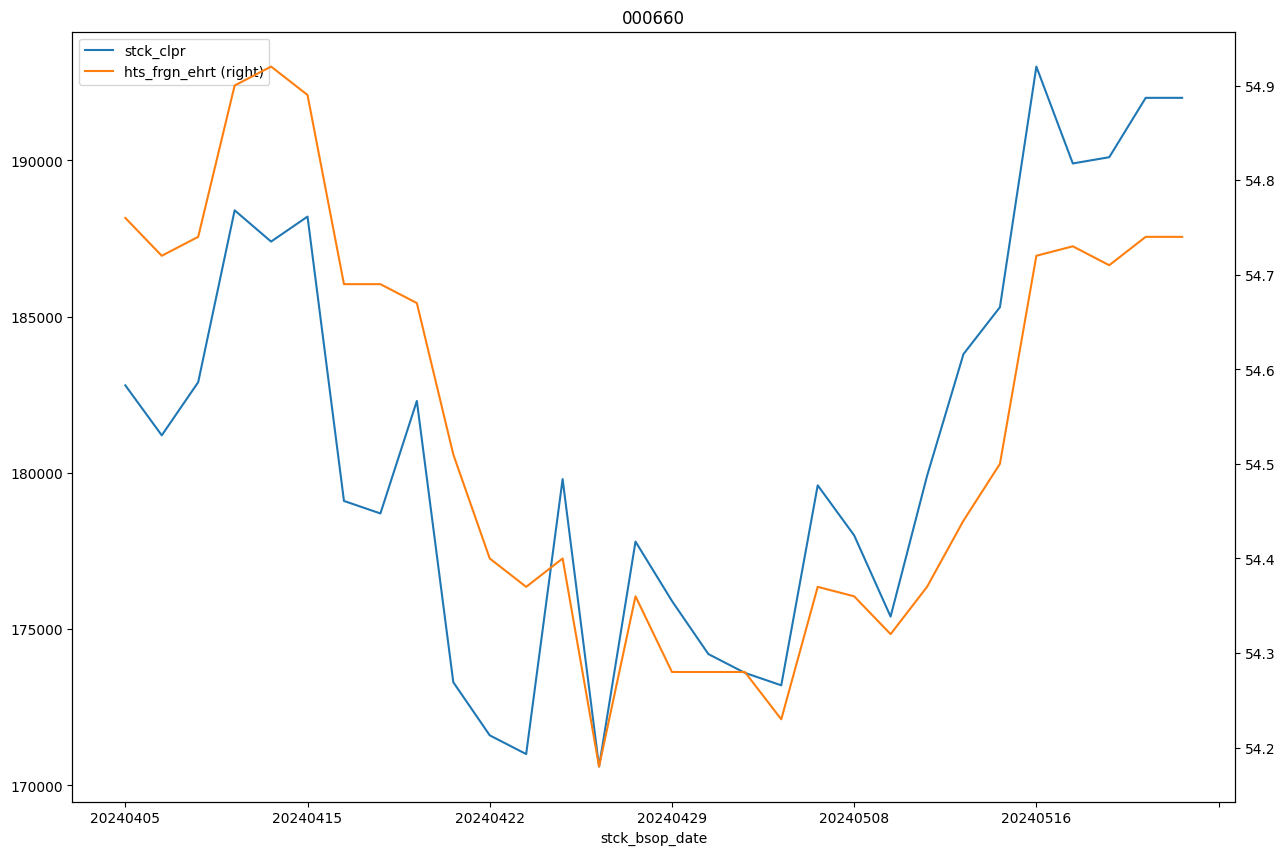

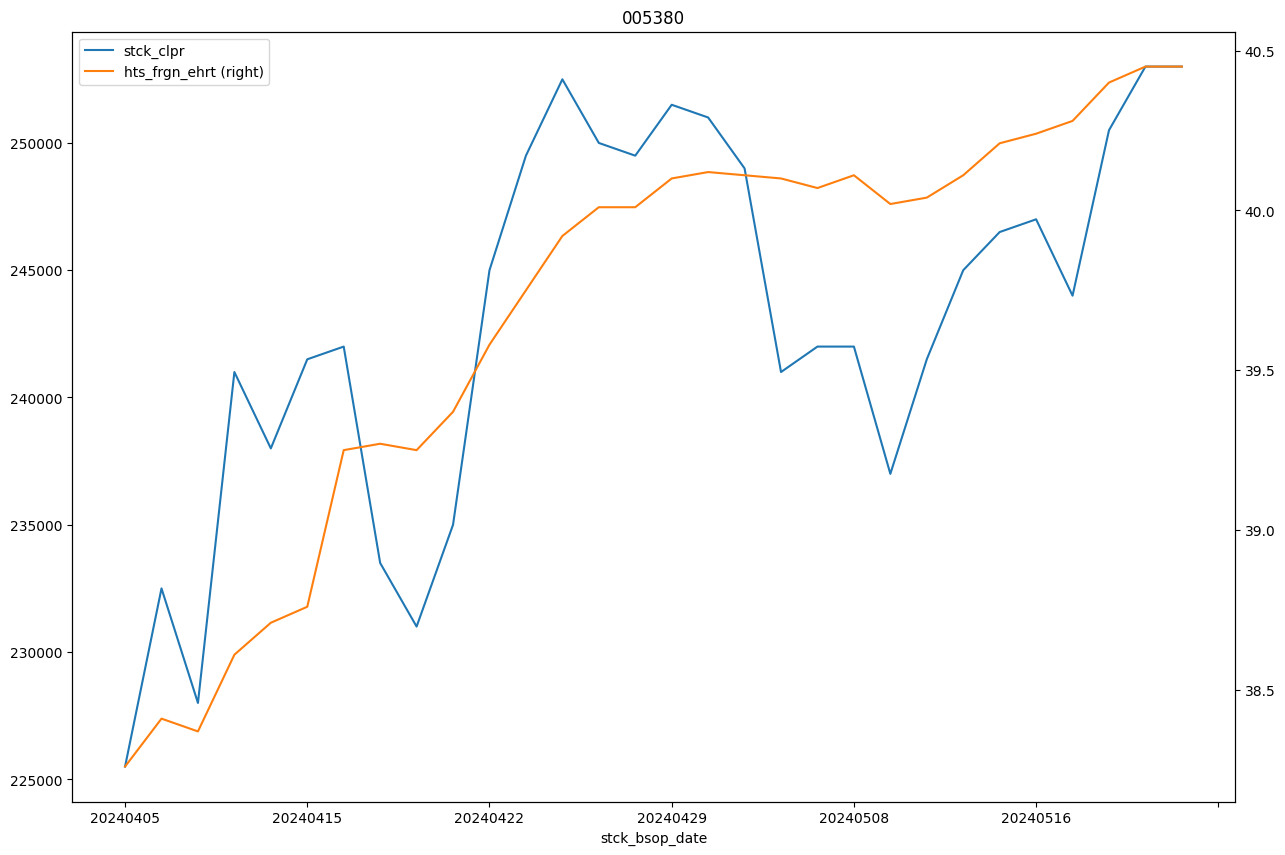

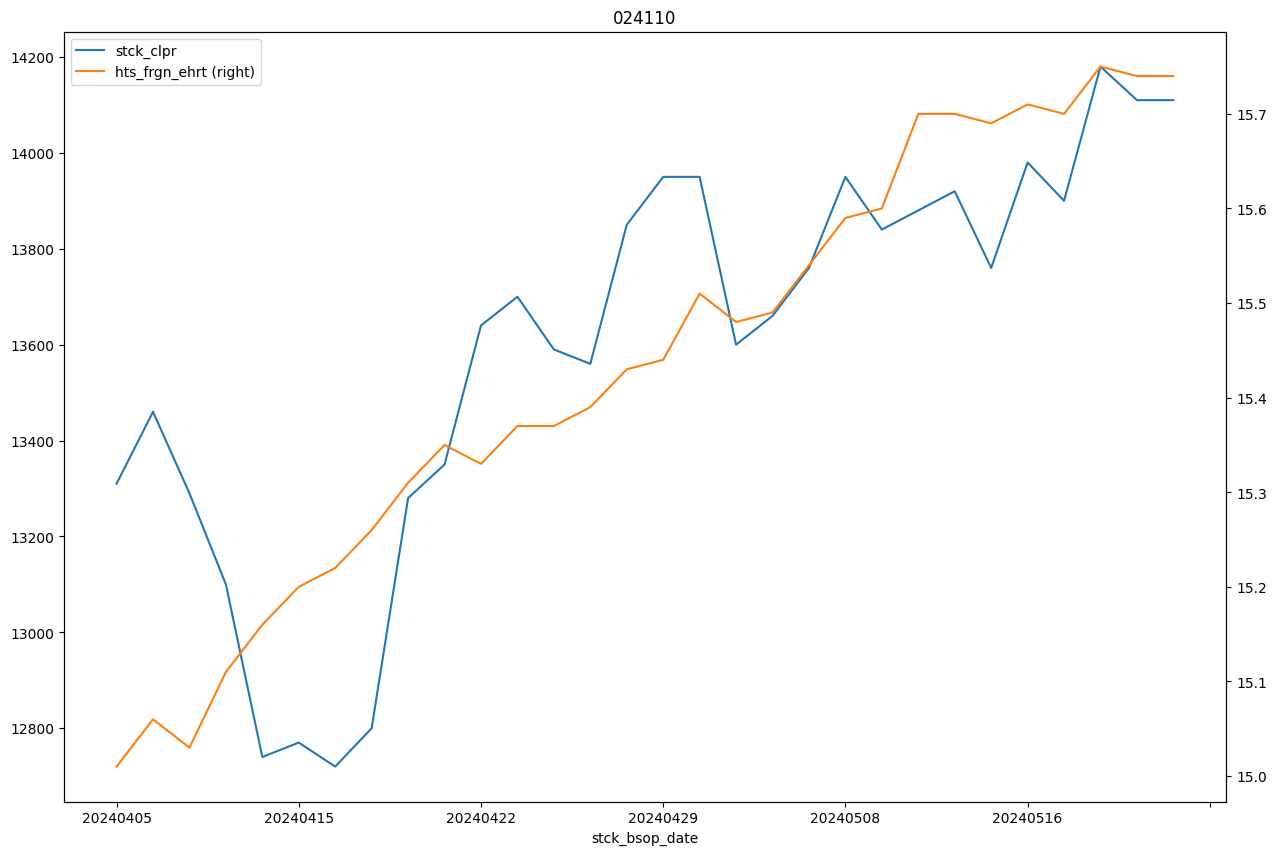

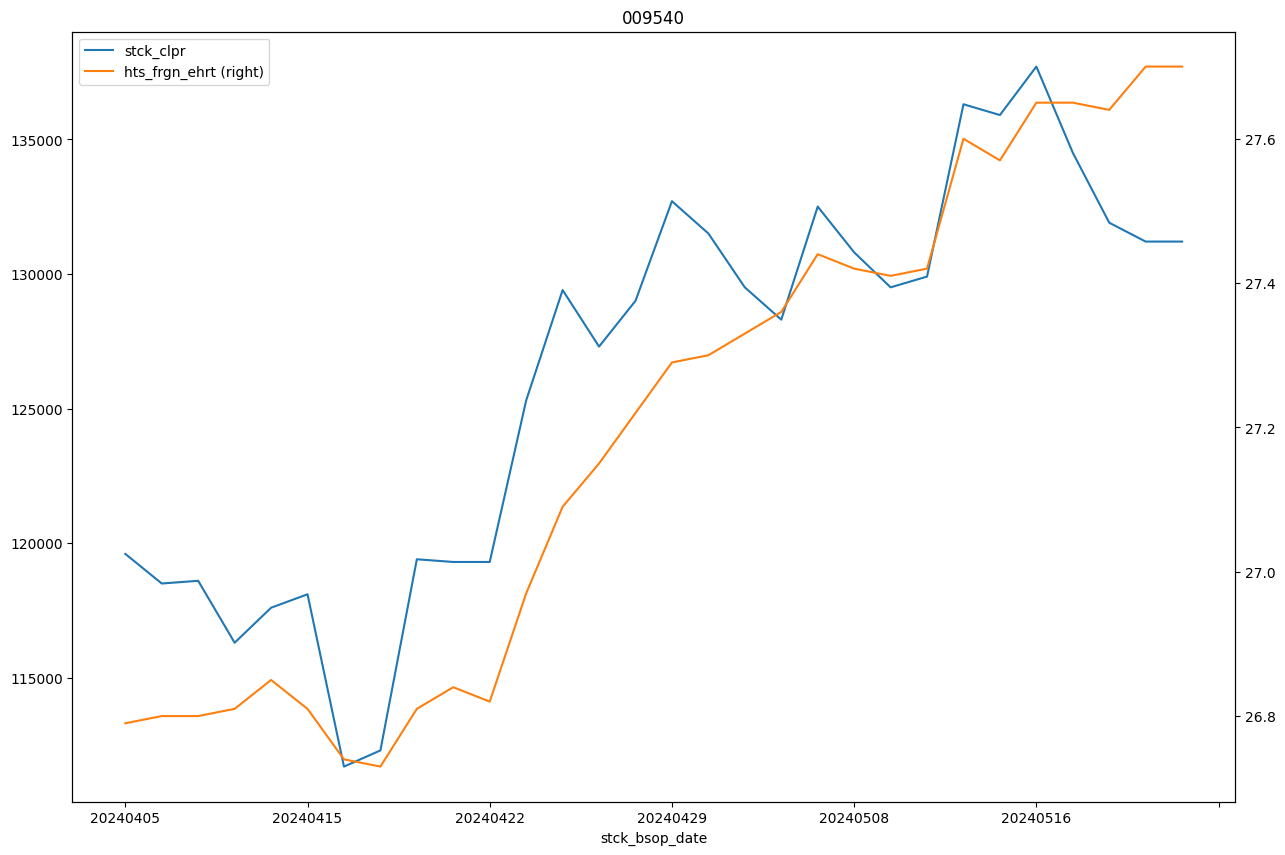

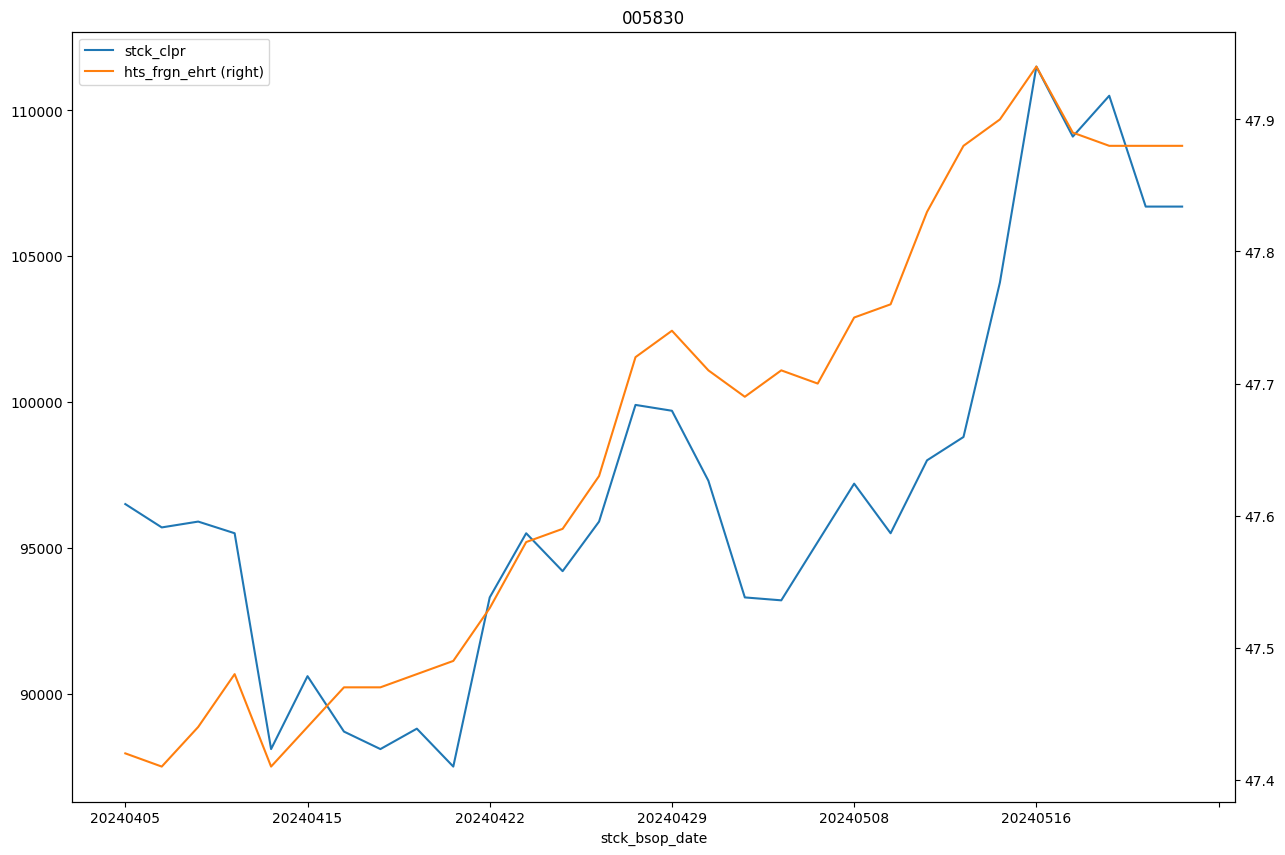

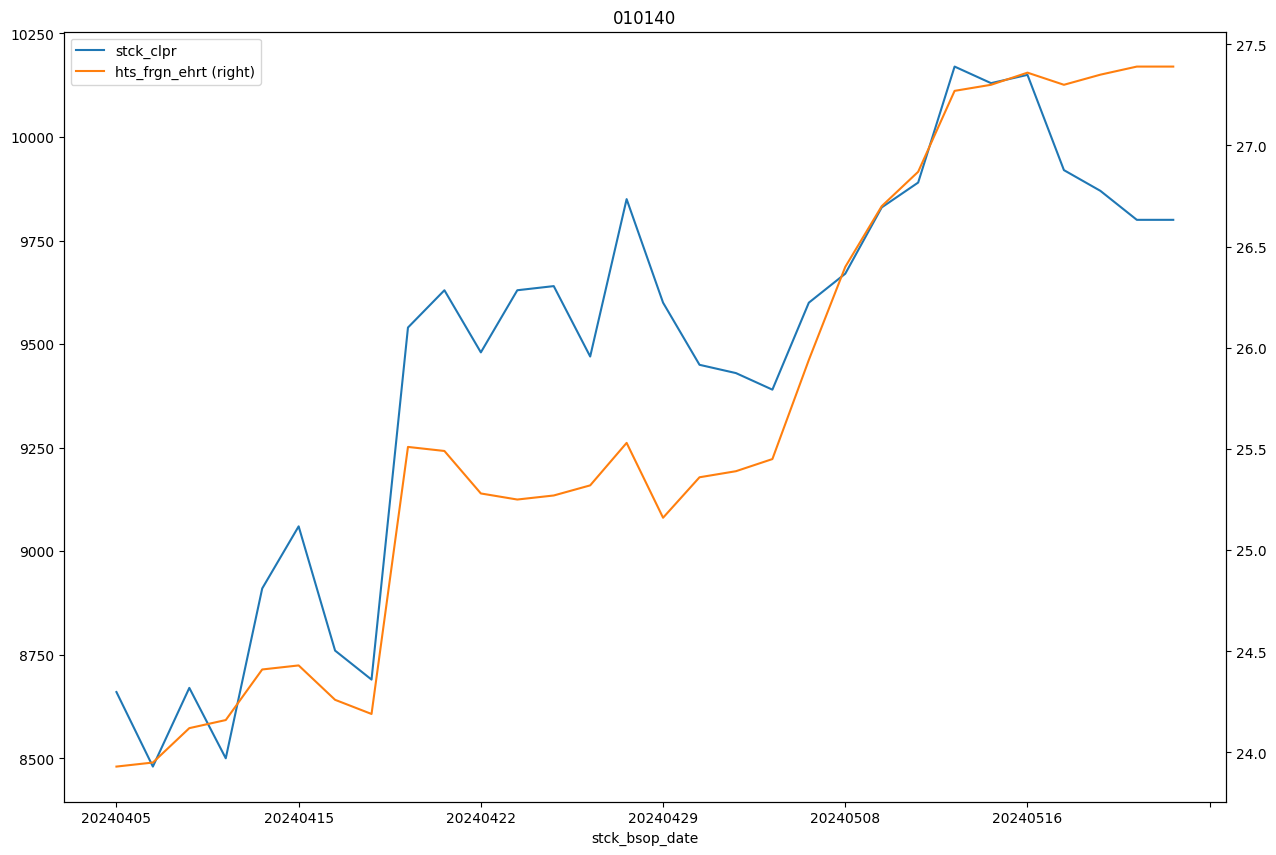

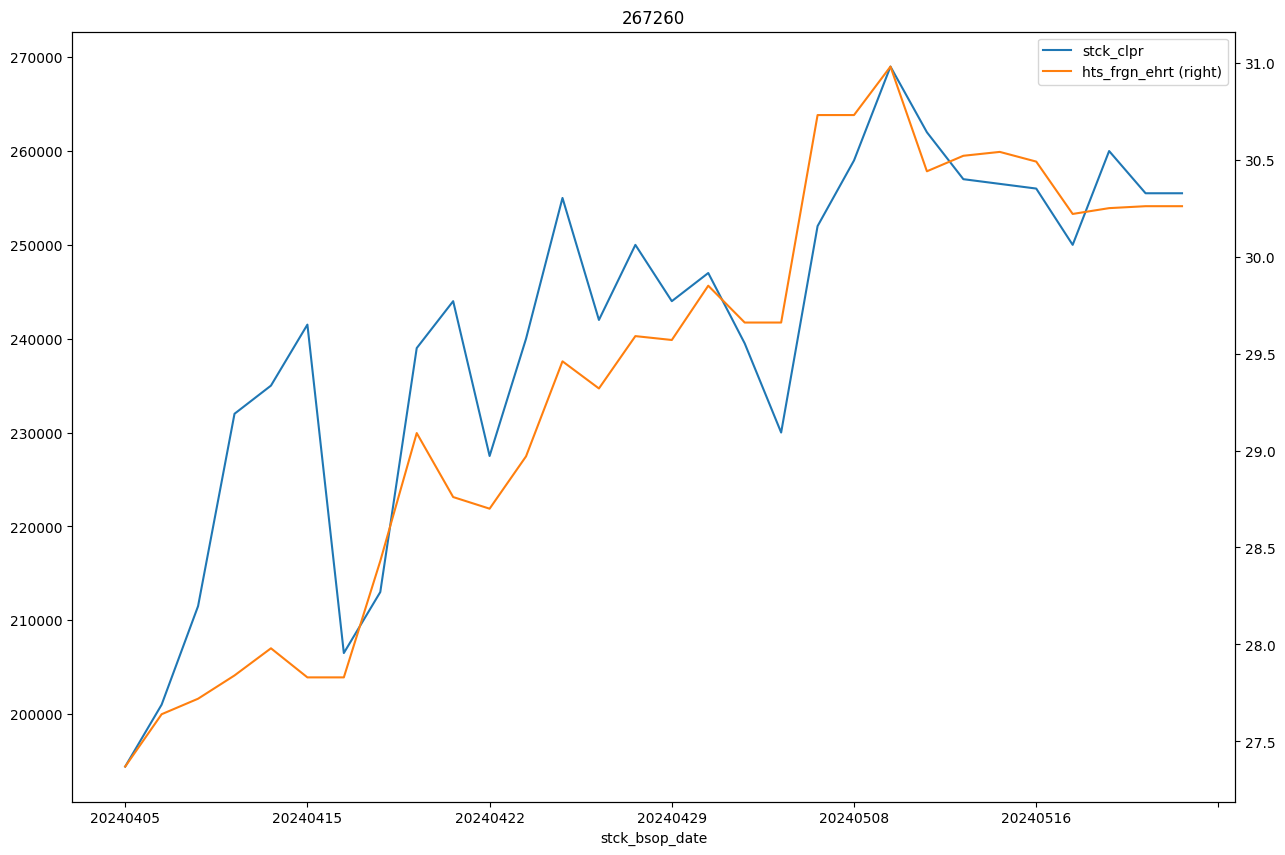

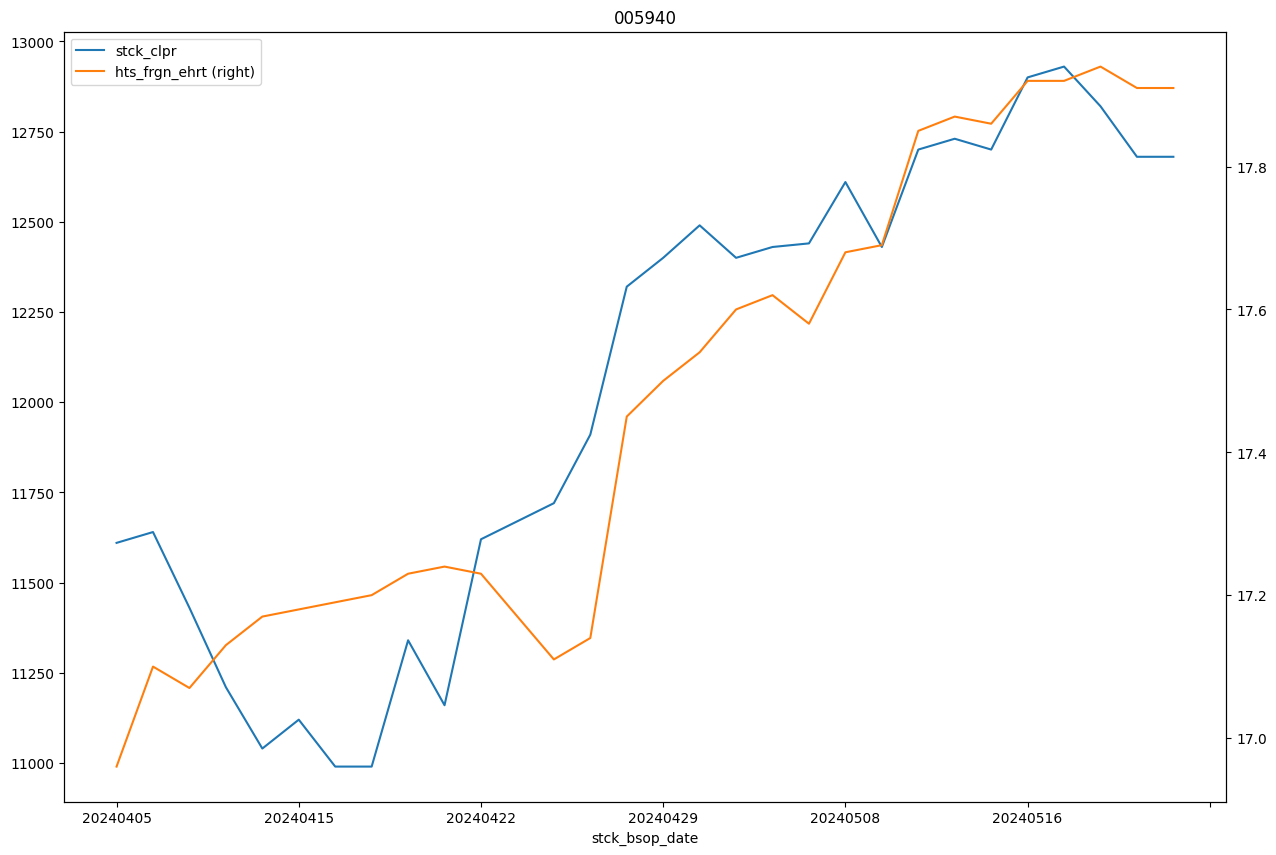

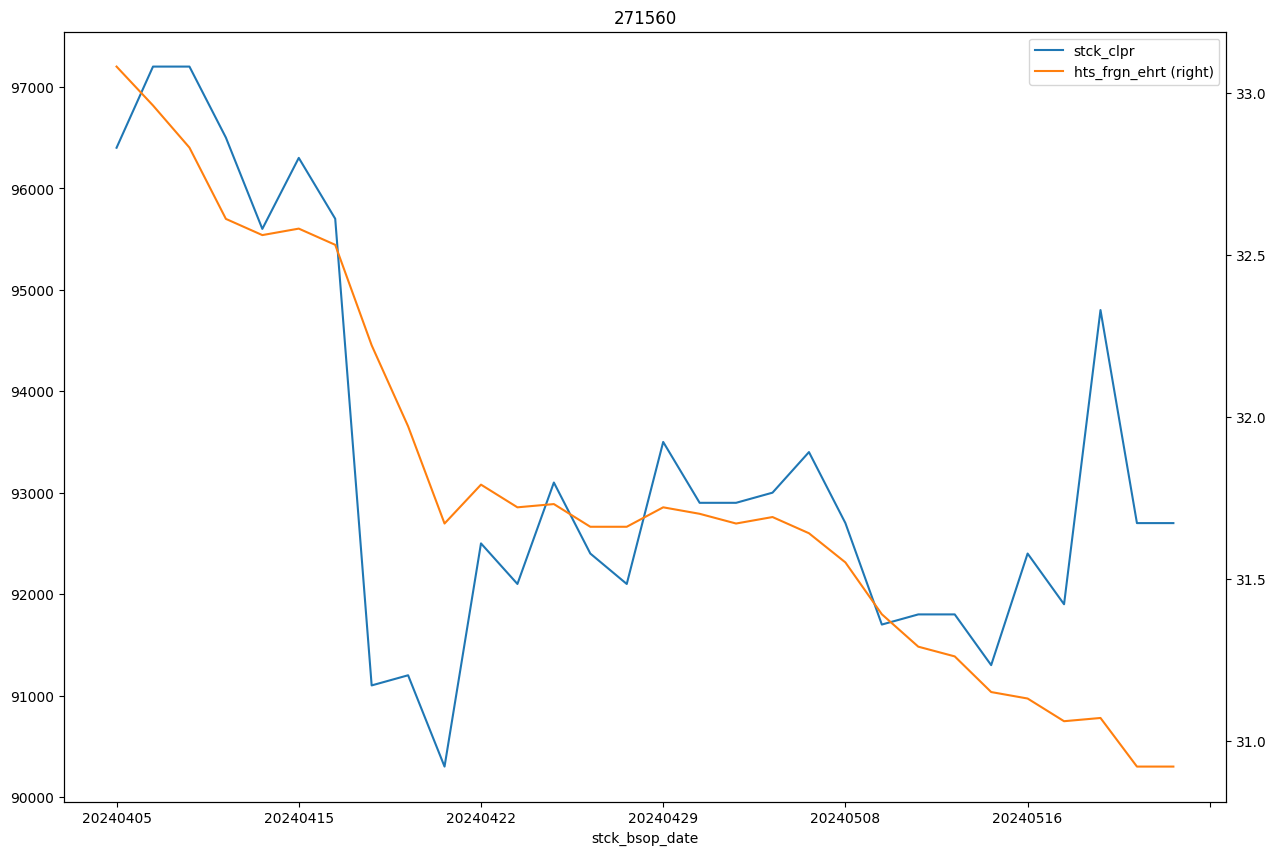

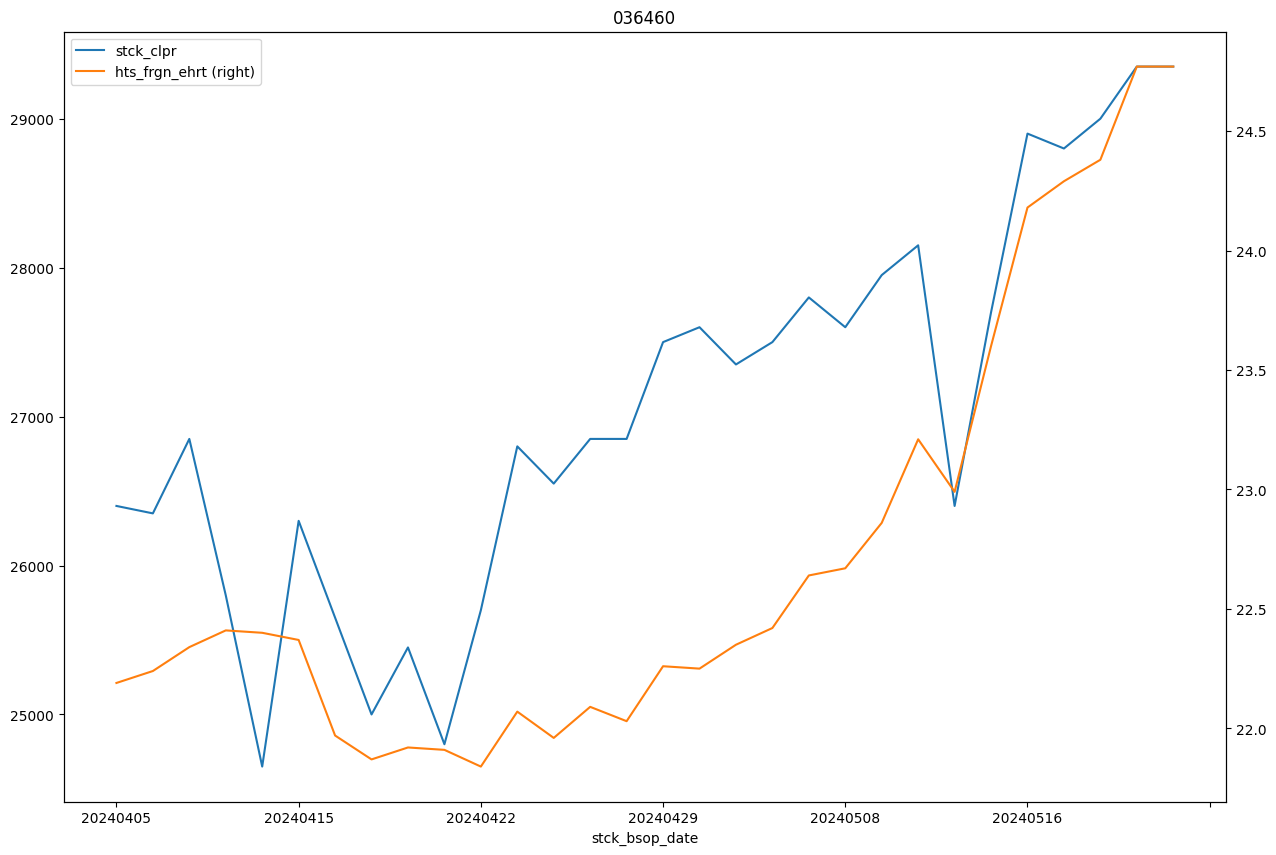

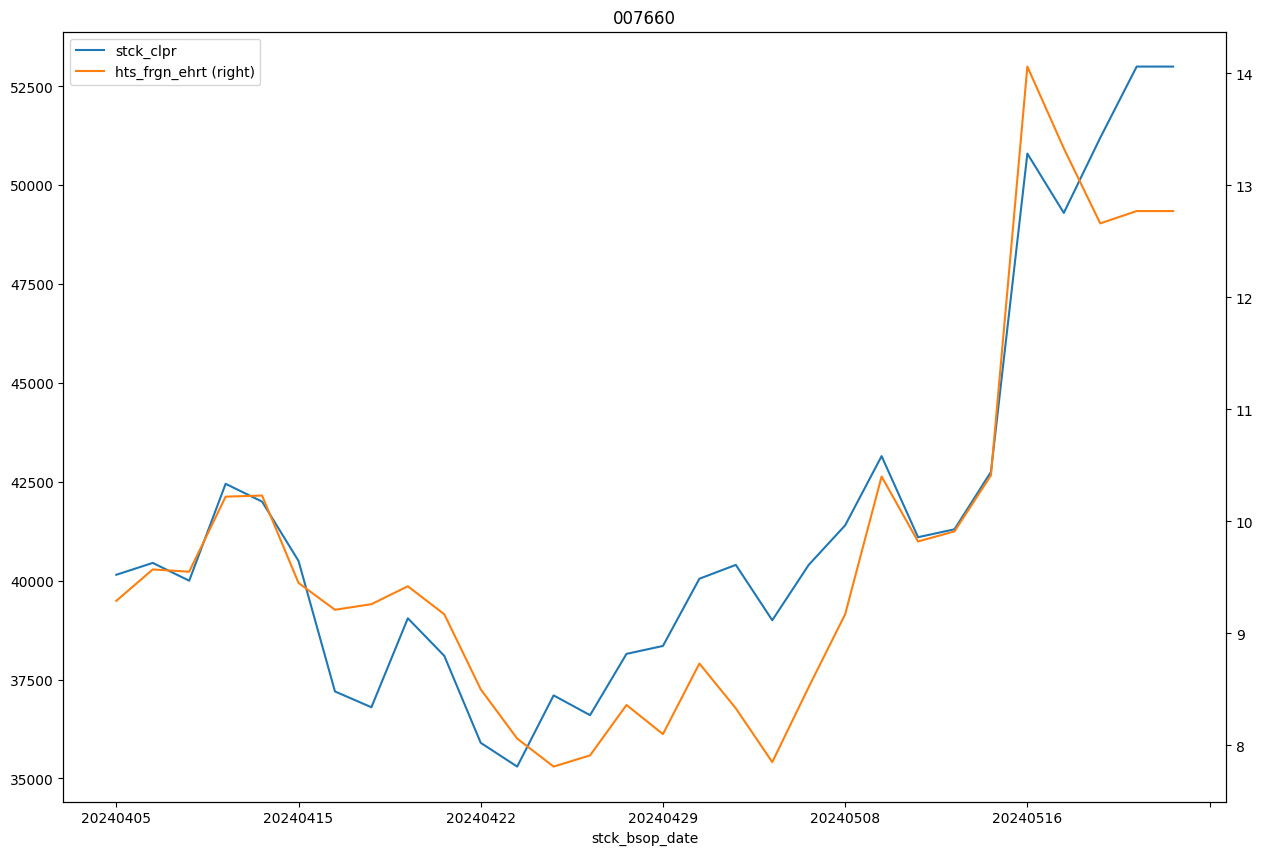

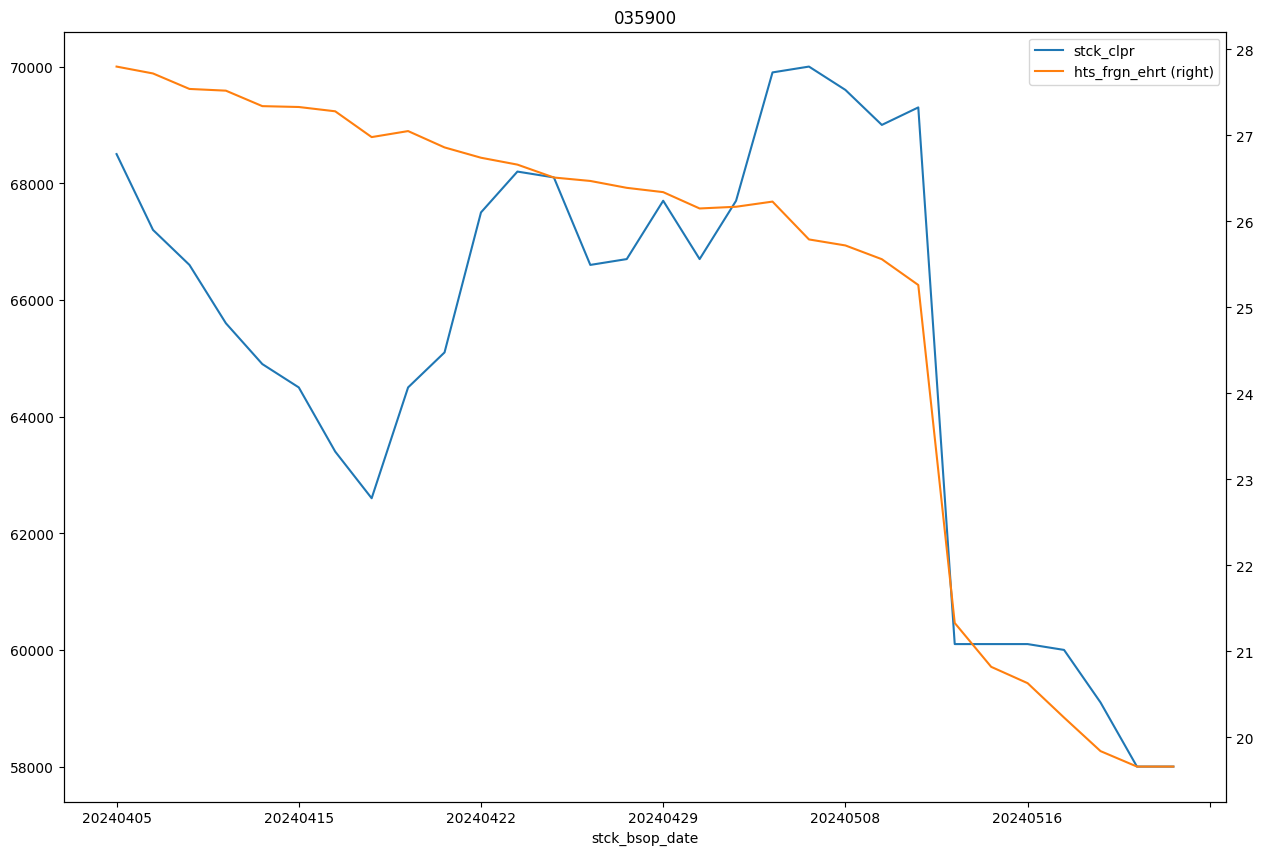

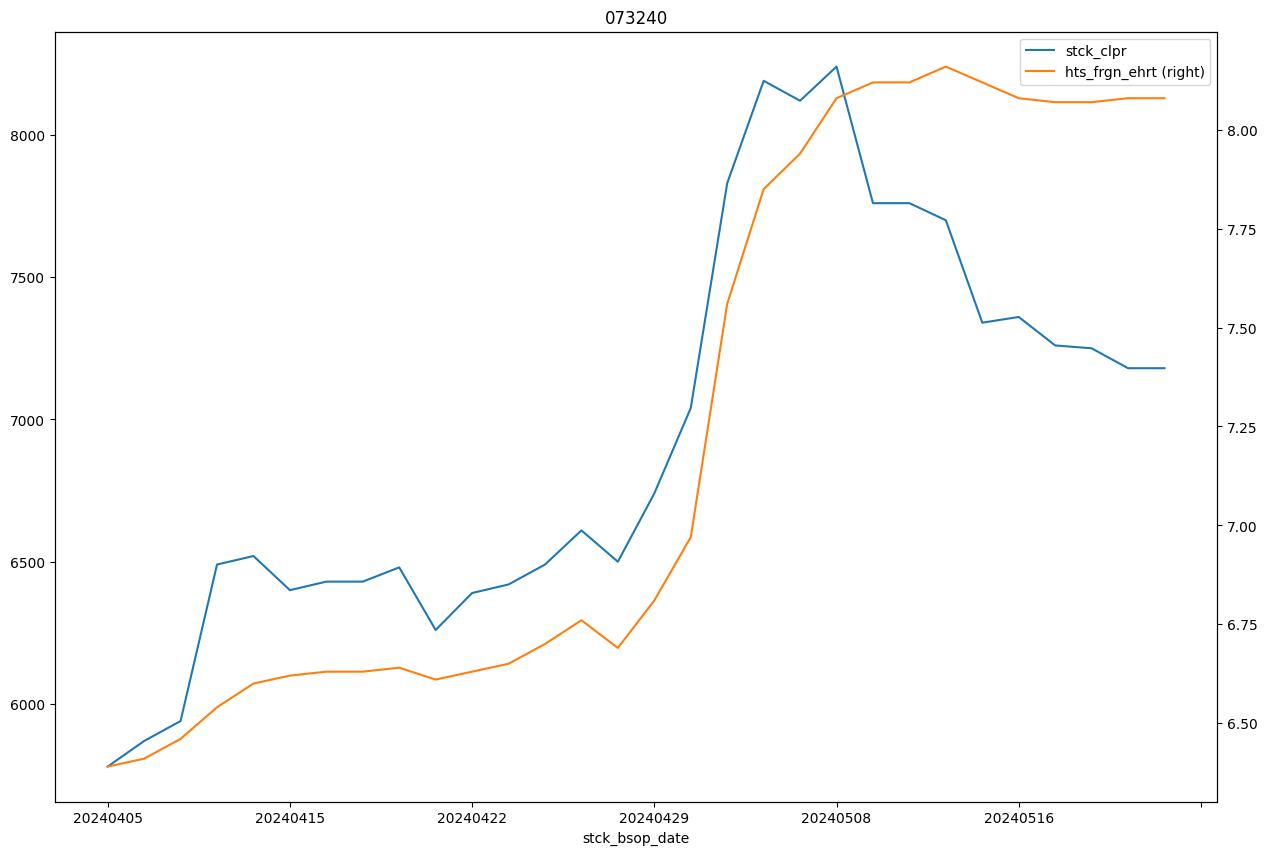

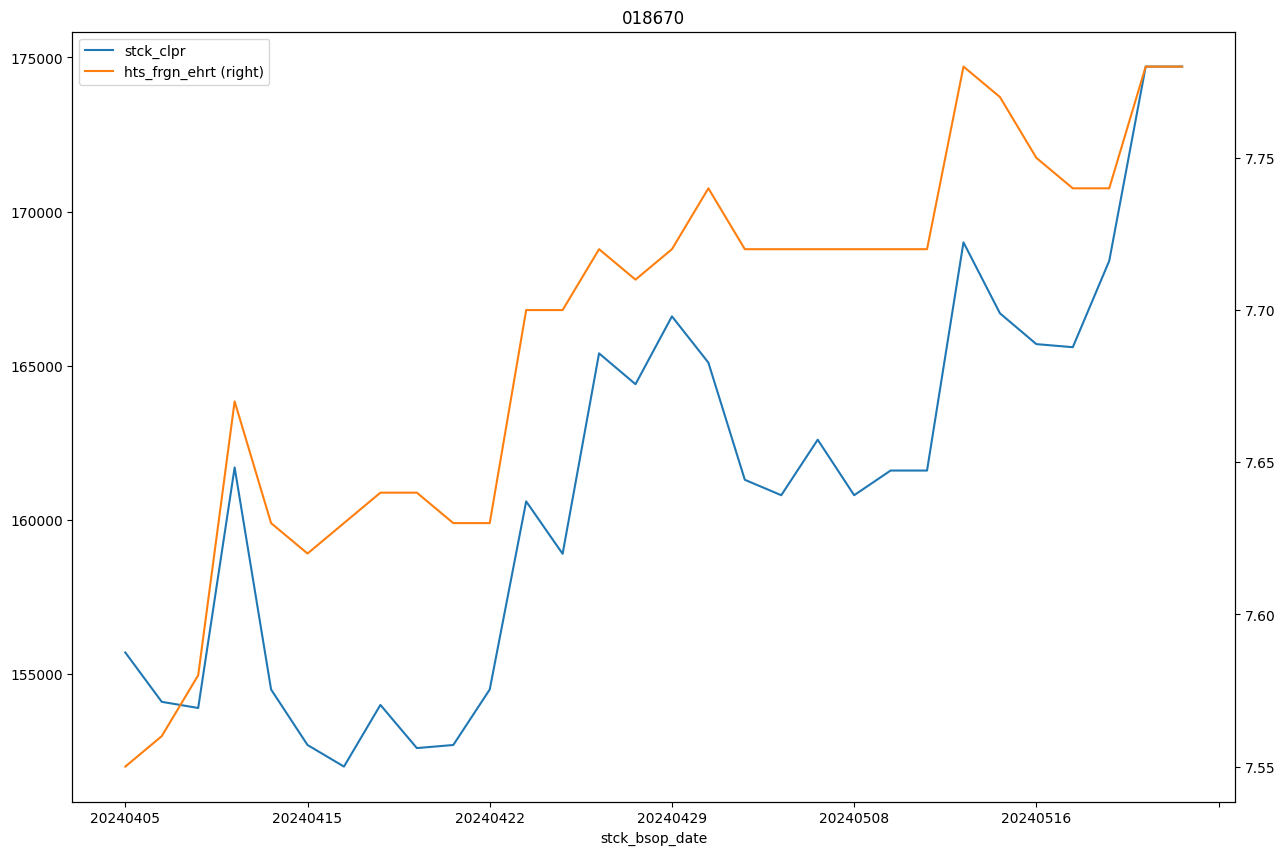

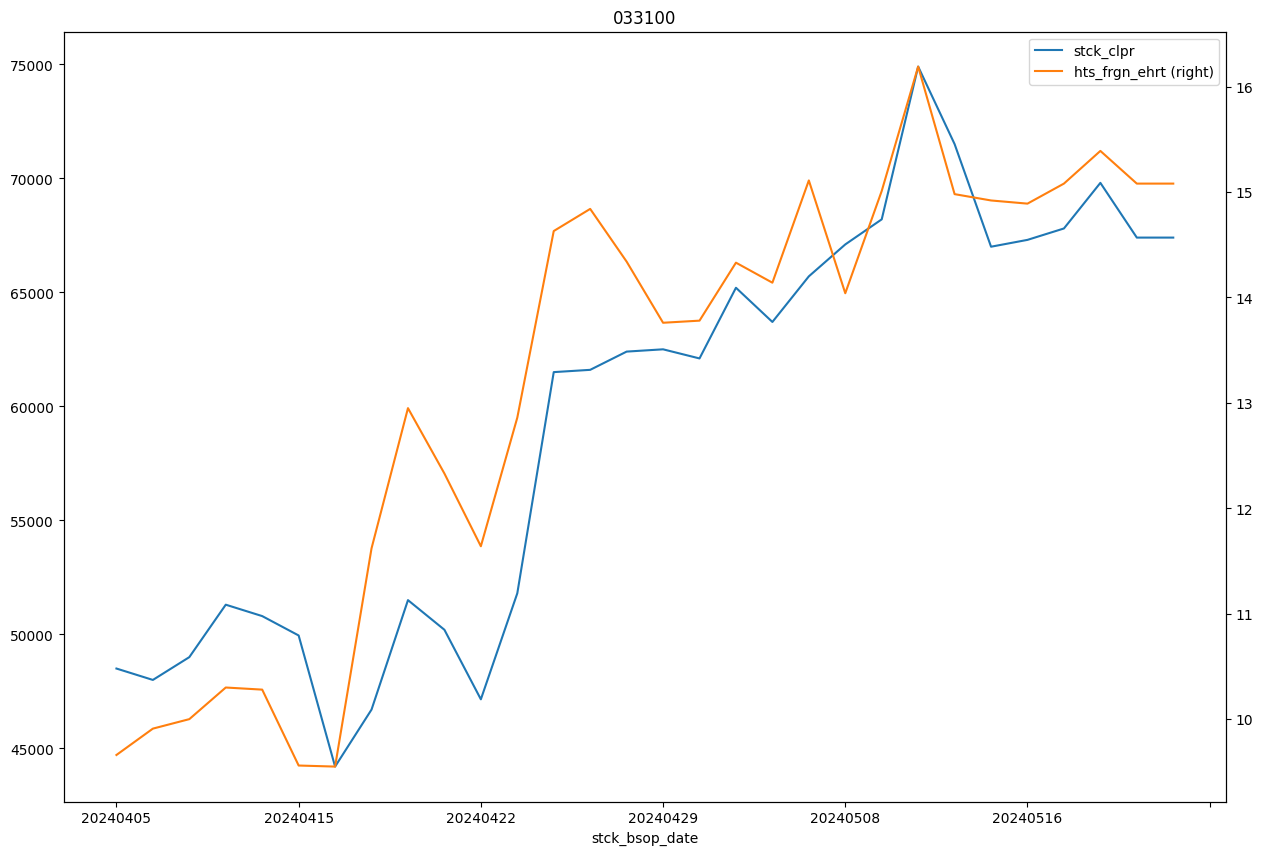

In [4]:

for code in corr_top['code']: 
    print(corr_top.loc[corr_top['code']==code, 'name'].values[0])
    fh, cr = fetch_foreign_holdings(code, 'D')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title=code)

In [5]:
def plot_fholdings(code):
    fh, cr = fetch_foreign_holdings(code, 'D')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='D')
    fh, cr = fetch_foreign_holdings(code, 'W')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='W')
    fh, cr = fetch_foreign_holdings(code, 'M')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='M')
    return None


In [6]:
# corr_inv comprises the companies that have high correlations with foreign investors with repsect to weekly(W) and monthly(M) data, but not with respect to daily(D) data
corr_inv = corr[corr[['w', 'm']].min(axis=1) > 0.7].sort_values('d')
display(corr_inv)

,code,d,w,m,name,average,std
298,950160,-0.789163,0.790735,0.925817,코오롱티슈진,0.309130,0.953544
229,137400,-0.342860,0.774078,0.753448,피엔티,0.394889,0.638992
224,281820,-0.339910,0.858662,0.938542,케이씨텍,0.485764,0.716170
91,064350,-0.268542,0.947873,0.842264,현대로템,0.507198,0.673883
26,028300,-0.148809,0.861710,0.848992,HLB,0.520631,0.579787
128,298040,-0.131231,0.755537,0.766250,효성중공업,0.463519,0.515096
0,005930,-0.124002,0.743291,0.905859,삼성전자,0.508383,0.553661
138,139480,0.147664,0.838501,0.752351,이마트,0.579506,0.376458
7,051910,0.169288,0.813326,0.793746,LG화학,0.592120,0.366314
97,018880,0.176712,0.737957,0.822952,한온시스템,0.579207,0.351152


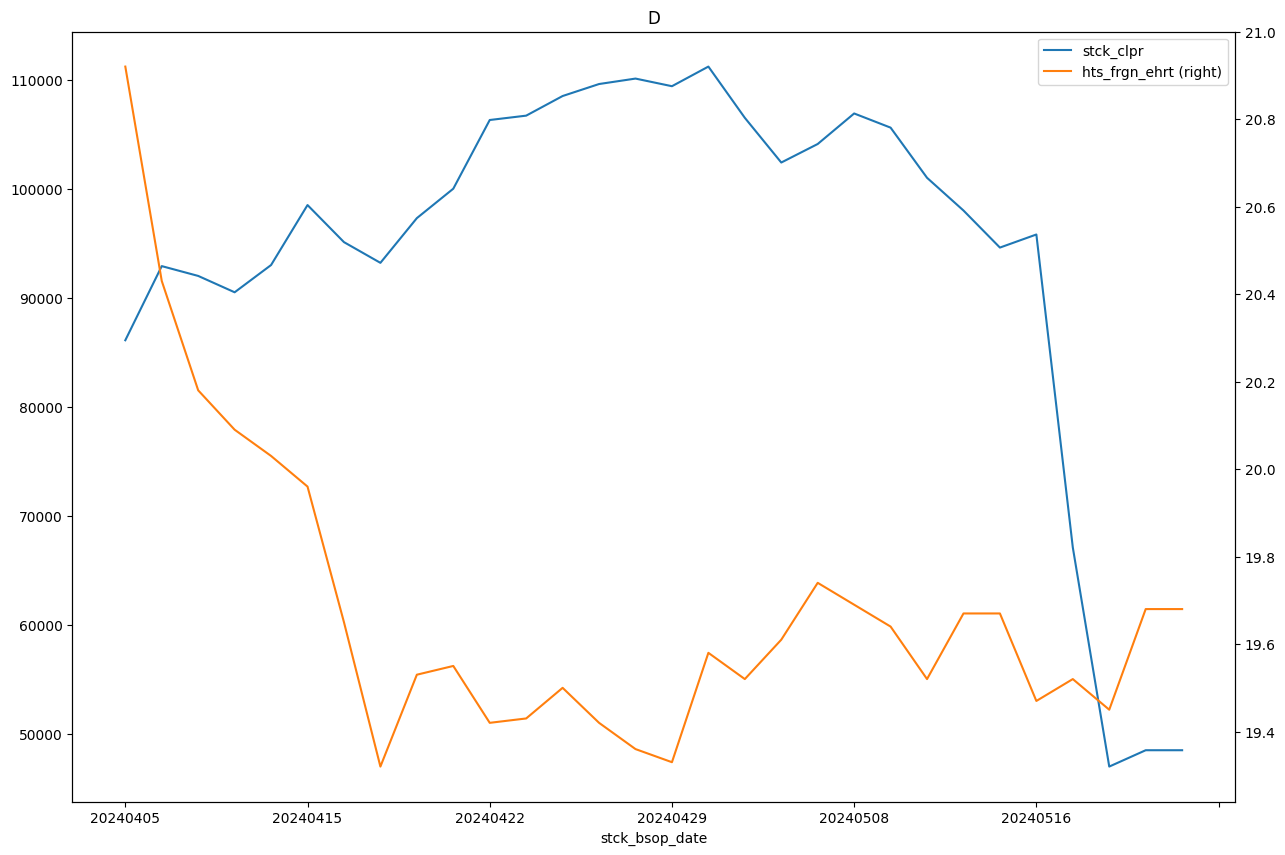

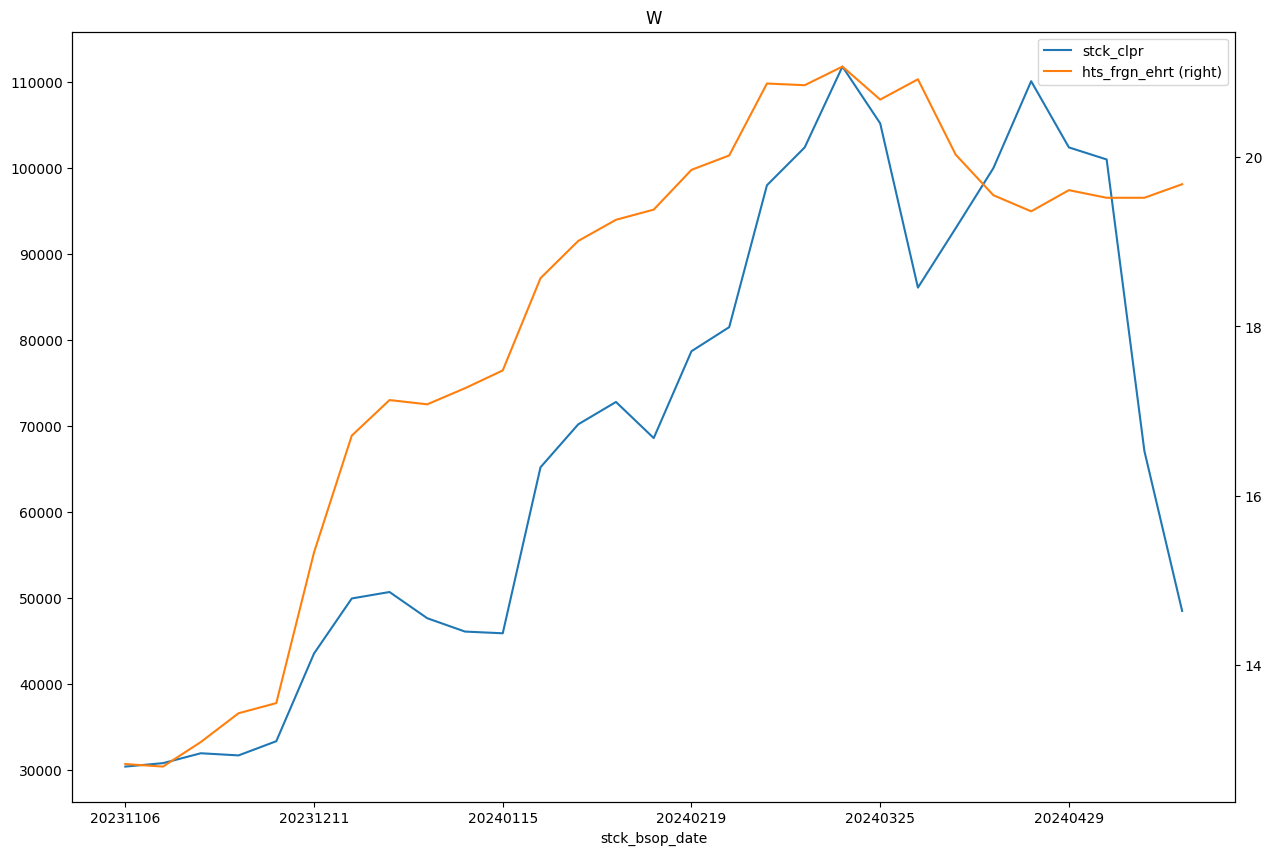

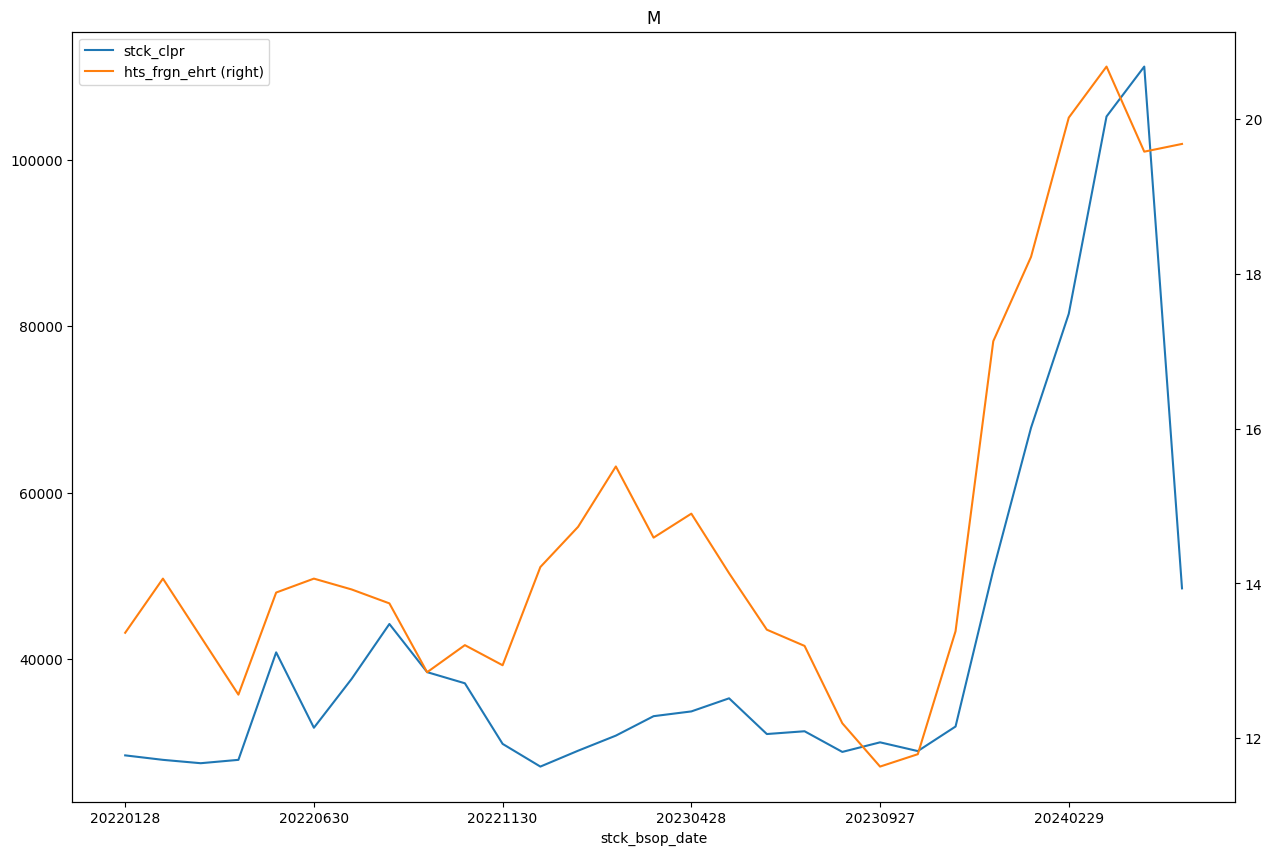

In [9]:
plot_fholdings('028300') #HLB

** Next Step **

- Develop an algorithm that generates a company health snapshot
    - financial health indicators (sales, op/net income, assets, loans, etc)
    - stock performance and trading volumes
    - foreigh holdings absolute amount
    - key issues (recent dart reports, news searches (?)) - they may require manual input

- Conduct an in-depth study of the companies highlighed in the previous analysis

- Create detailed and specific trading strategies to implement in codes eventually